In [3]:
# Chạy 1 lần để cài package (có thể comment sau khi đã cài)
%pip install pandas numpy matplotlib scikit-learn prophet ipywidgets plotly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 914.9/914.9 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 34.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [ipywidgets]5 [ipywidgets]

[notice] A new release of pip is available: 25.1.1 -> 26.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
Block 1: Khai báo thư viện và Nạp dữ liệu (Tier 3)
Phần này thực hiện việc nạp dữ liệu từ file CSV đã chuẩn hóa ở mức Tier 3.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from prophet import Prophet
from datetime import datetime, timedelta

# Nạp tập dữ liệu lịch sử (Historical-data) [cite: 9, 12]
df = pd.read_csv('historical_server_logs_10days.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Chọn Instance cần phân tích (Ví dụ: Web-Server-01) [cite: 7]
target_instance = 'Web-Server-01'
df_target = df[df['instance_id'] == target_instance].sort_values('timestamp')

print(f"Đã nạp {len(df_target)} bản ghi cho {target_instance}")

Đã nạp 1920 bản ghi cho Web-Server-01


Block 2: Pha 1 - Huấn luyện Machine Learning (Training)
Sử dụng đồng thời Linear Regression và Prophet để training dữ liệu.


In [13]:
# 1. Training với Linear Regression (Tính xu hướng nhanh) [cite: 11]
df_target['minutes'] = (df_target['timestamp'] - df_target['timestamp'].min()).dt.total_seconds() / 60
X = df_target[['minutes']].values
y = df_target['value'].values
lr_model = LinearRegression().fit(X, y)

# 2. Training với Prophet (Dự báo chu kỳ Time-series) [cite: 11, 20]
df_prophet = df_target[['timestamp', 'value']].rename(columns={'timestamp': 'ds', 'value': 'y'})
m = Prophet(daily_seasonality=True, weekly_seasonality=True)
m.fit(df_prophet)

# Tạo dữ liệu dự báo (Prediction data) cho 120 phút tới [cite: 13, 16]
future = m.make_future_dataframe(periods=12, freq='10min') 
forecast = m.predict(future)
prediction_results = forecast[forecast['ds'] > df_target['timestamp'].max()]

22:57:07 - cmdstanpy - INFO - Chain [1] start processing
22:57:07 - cmdstanpy - INFO - Chain [1] done processing


Block 3: Pha 2 - Phân loại Rủi ro (Risk Classification)
Tính toán khoảng cách thời gian (Offset) để phân loại mức độ nguy cấp

In [15]:
threshold = 90 # Ngưỡng rủi ro High usage [cite: 17, 25]
risk_entry = prediction_results[prediction_results['yhat'] >= threshold]

risk_label = "NORMAL"
offset = None

if not risk_entry.empty:
    t_risk = risk_entry['ds'].iloc[0]
    # Tính Offset từ thời điểm hiện tại [cite: 26]
    offset = (t_risk - datetime.now()).total_seconds() / 60
    
    # Logic phân loại theo tài liệu [cite: 26, 27, 28, 29]
    if offset < 30:
        risk_label = "CRITICAL" # Offset < 30 [cite: 26]
    elif 30 <= offset <= 50:
        risk_label = "MAJOR"    # 30 < offset < 50 [cite: 27]
    elif offset > 90:
        risk_label = "MINOR"    # offset > 90 [cite: 28]

print(f"Kết quả phân loại Rủi ro: {risk_label} (Offset: {offset} phút)")

Kết quả phân loại Rủi ro: NORMAL (Offset: None phút)


Block 4: Tính toán Cơ hội Tiết kiệm (Cost Saving)
Áp dụng công thức tính toán cho các trường hợp Low usage.

In [16]:
# Lấy giá trị cấu hình từ dataset [cite: 32]
mem_gb = df_target['memory_gb'].iloc[0]
storage_gb = df_target['storage_gb'].iloc[0]

# Công thức: (Storage + Memory) * 30 ngày [cite: 32]
# Giả sử đơn giá là 1 USD/GB để minh họa
monthly_saving = (storage_gb + mem_gb) * 1 * 30 

opp_label = "NORMAL"
# Nếu usage thấp và có khả năng tiết kiệm [cite: 18, 21, 22]
if df_target['value'].mean() < 20: 
    if monthly_saving > 100:
        opp_label = "HIGH"   # Cost saving > 100usd [cite: 22]
    else:
        opp_label = "MEDIUM/LOW"

print(f"Cơ hội tiết kiệm: {opp_label} (Dự kiến: ${monthly_saving}/tháng)")

Cơ hội tiết kiệm: NORMAL (Dự kiến: $1740/tháng)


Block 5: Trực quan hóa (Visualization)
Sử dụng Matplotlib để xuất biểu đồ từ dữ liệu lưu tại KV Store.

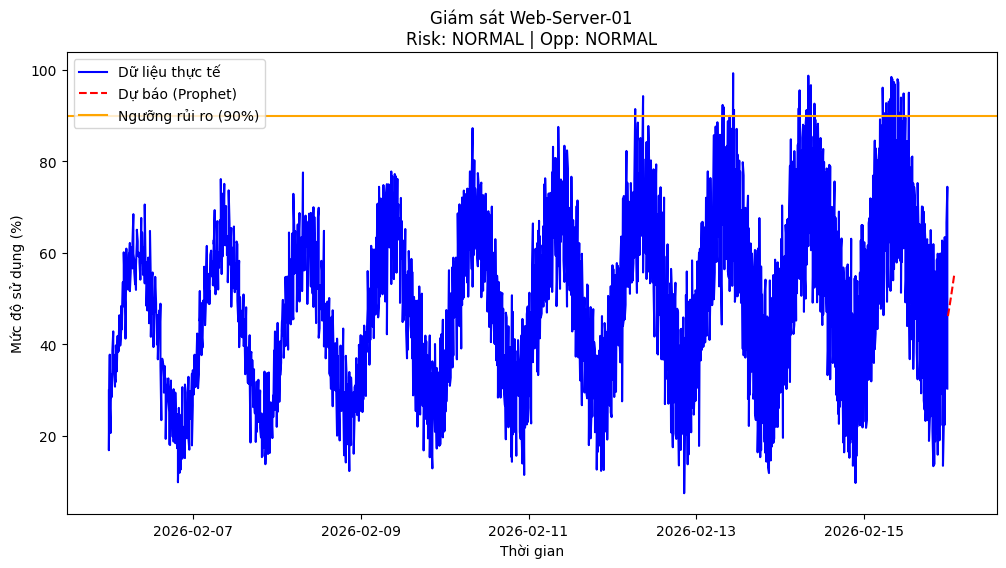

In [17]:
plt.figure(figsize=(12, 6))
# Vẽ dữ liệu lịch sử (Historical-data) [cite: 9]
plt.plot(df_target['timestamp'], df_target['value'], label='Dữ liệu thực tế', color='blue')
# Vẽ dữ liệu dự báo (Prediction) [cite: 13]
plt.plot(prediction_results['ds'], prediction_results['yhat'], label='Dự báo (Prophet)', color='red', linestyle='--')

plt.axhline(y=90, color='orange', label='Ngưỡng rủi ro (90%)')
plt.title(f"Giám sát {target_instance}\nRisk: {risk_label} | Opp: {opp_label}")
plt.xlabel("Thời gian")
plt.ylabel("Mức độ sử dụng (%)")
plt.legend()
plt.show()

Block 6: Hệ thống Thông báo & Tối ưu Chi phí (Take Action)

In [12]:
def process_server_actions(instance_id, risk_label, offset, avg_usage, mem_gb, storage_gb):
    print(f"--- [HỆ THỐNG QUẢN TRỊ TÀI NGUYÊN TỰ ĐỘNG] ---")
    print(f"Server Instance: {instance_id}")
    print("-" * 45)

    # 1. PHẦN QUẢN TRỊ RỦI RO (RISK MANAGEMENT)
    if risk_label != "NORMAL":
        print(f"🚨 TRẠNG THÁI RỦI RO: {risk_label}")
        if risk_label == "CRITICAL":
            print(f"⚠️ CẢNH BÁO: Chạm ngưỡng quá tải trong {round(offset, 1)} phút!")
            print(f"🛠️ HÀNH ĐỘNG: LLM yêu cầu AUTO-SCALING ngay lập tức.")
        elif risk_label == "MAJOR":
            print(f"📝 GHI CHÚ: Nguy cơ xảy ra trong {round(offset, 1)} phút.")
            print(f"📋 HÀNH ĐỘNG: Giải phóng bộ nhớ đệm (Cache) và tối ưu tiến trình.")
        elif risk_label == "MINOR":
            print(f"ℹ️ THÔNG TIN: Xu hướng tăng nhẹ (Offset: {round(offset, 1)}m).")
            print(f"🔍 HÀNH ĐỘNG: Tiếp tục ghi nhận log vào Tier 3.")
    else:
        print(f"✅ RỦI RO: NORMAL (Server vận hành ổn định)")

    print("-" * 45)

    # 2. PHẦN TỐI ƯU CHI PHÍ (OPPORTUNITY - COST SAVING)
    # Công thức: Saving = (Storage + Memory) * 30
    monthly_saving = (mem_gb + storage_gb) * 30
    
    # Xác định mức độ Opportunity dựa trên Low Usage (< 20%) và số tiền tiết kiệm
    opp_label = "NORMAL"
    if avg_usage < 20:
        if monthly_saving > 100:
            opp_label = "HIGH"
        elif monthly_saving > 50:
            opp_label = "MEDIUM"
        else:
            opp_label = "LOW"

    if opp_label != "NORMAL":
        print(f"💰 CƠ HỘI TIẾT KIỆM (OPPORTUNITY): {opp_label}")
        print(f"💵 SỐ TIỀN DỰ KIẾN: ${monthly_saving} / tháng")
        if opp_label == "HIGH":
            print(f"💡 ĐỀ XUẤT: Server đang dư thừa tài nguyên lớn. LLM khuyên nên Hạ cấp (Downsize).")
    else:
        print(f"🍃 CHI PHÍ: Tối ưu (Không có dư thừa tài nguyên đáng kể)")

# --- CHẠY THỬ NGHIỆM ---
# Lấy các thông số từ dữ liệu thực tế trong Notebook của Ngọc
avg_val = df_target['value'].mean()
m_gb = df_target['memory_gb'].iloc[0]
s_gb = df_target['storage_gb'].iloc[0]

process_server_actions(target_instance, risk_label, offset if offset else 0, avg_val, m_gb, s_gb)

--- [HỆ THỐNG QUẢN TRỊ TÀI NGUYÊN TỰ ĐỘNG] ---
Server Instance: Web-Server-01
---------------------------------------------
✅ RỦI RO: NORMAL (Server vận hành ổn định)
---------------------------------------------
🍃 CHI PHÍ: Tối ưu (Không có dư thừa tài nguyên đáng kể)
